# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

2025-07-29 17:51:07.539168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv("/Users/abhay/Downloads/AAPL.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10987 entries, 0 to 10986
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10987 non-null  int64  
 1   Date        10987 non-null  object 
 2   Open        10987 non-null  float64
 3   High        10987 non-null  float64
 4   Low         10987 non-null  float64
 5   Close       10987 non-null  float64
 6   Volume      10987 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 601.0+ KB


In [5]:
df.isna().sum()

Unnamed: 0    0
Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df = df.head(10000)

In [8]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,1980-12-12,0.099058,0.099488,0.099058,0.099058,469033600
1,1,1980-12-15,0.094321,0.094321,0.093890,0.093890,175884800
2,2,1980-12-16,0.087429,0.087429,0.086999,0.086999,105728000
3,3,1980-12-17,0.089152,0.089582,0.089152,0.089152,86441600
4,4,1980-12-18,0.091737,0.092167,0.091737,0.091737,73449600


# Removing "Unnamed: 0" column

In [9]:
df.drop(columns={'Unnamed: 0'}, axis=1, inplace=True)

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.set_index('Date', inplace=True)

In [12]:
df.describe()

,Open,High,Low,Close,Volume
count,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,8.113231,8.197937,8.031088,8.118376,3.415299e+08
std,15.485852,15.656904,15.336855,15.509474,3.428621e+08
min,0.038331,0.038331,0.037900,0.037900,0.000000e+00
25%,0.224347,0.229159,0.219666,0.224630,1.315009e+08
50%,0.359405,0.366472,0.352724,0.359744,2.288338e+08
75%,8.137407,8.181943,8.068333,8.126159,4.256994e+08
max,110.757043,111.736983,107.907525,111.238907,7.421641e+09


In [13]:
# Using 'Close' price for Time Series Analysis
ts = df['Close']

# Data Visualization

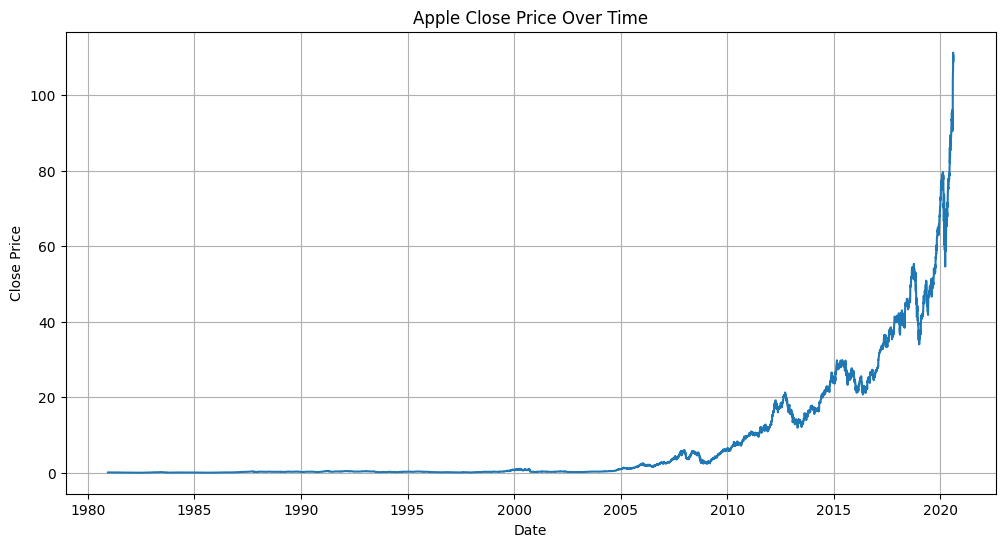

In [14]:
plt.figure(figsize=(12,6))
plt.plot(ts)
plt.title('Apple Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

# Time Series Decomposition for Identify the behaviour of Stock

In [15]:
decompose_additive = seasonal_decompose(ts, model='additive', period=30)
trend_additive = decompose_additive.trend
seasonal_additive = decompose_additive.seasonal
resid_additive = decompose_additive.resid

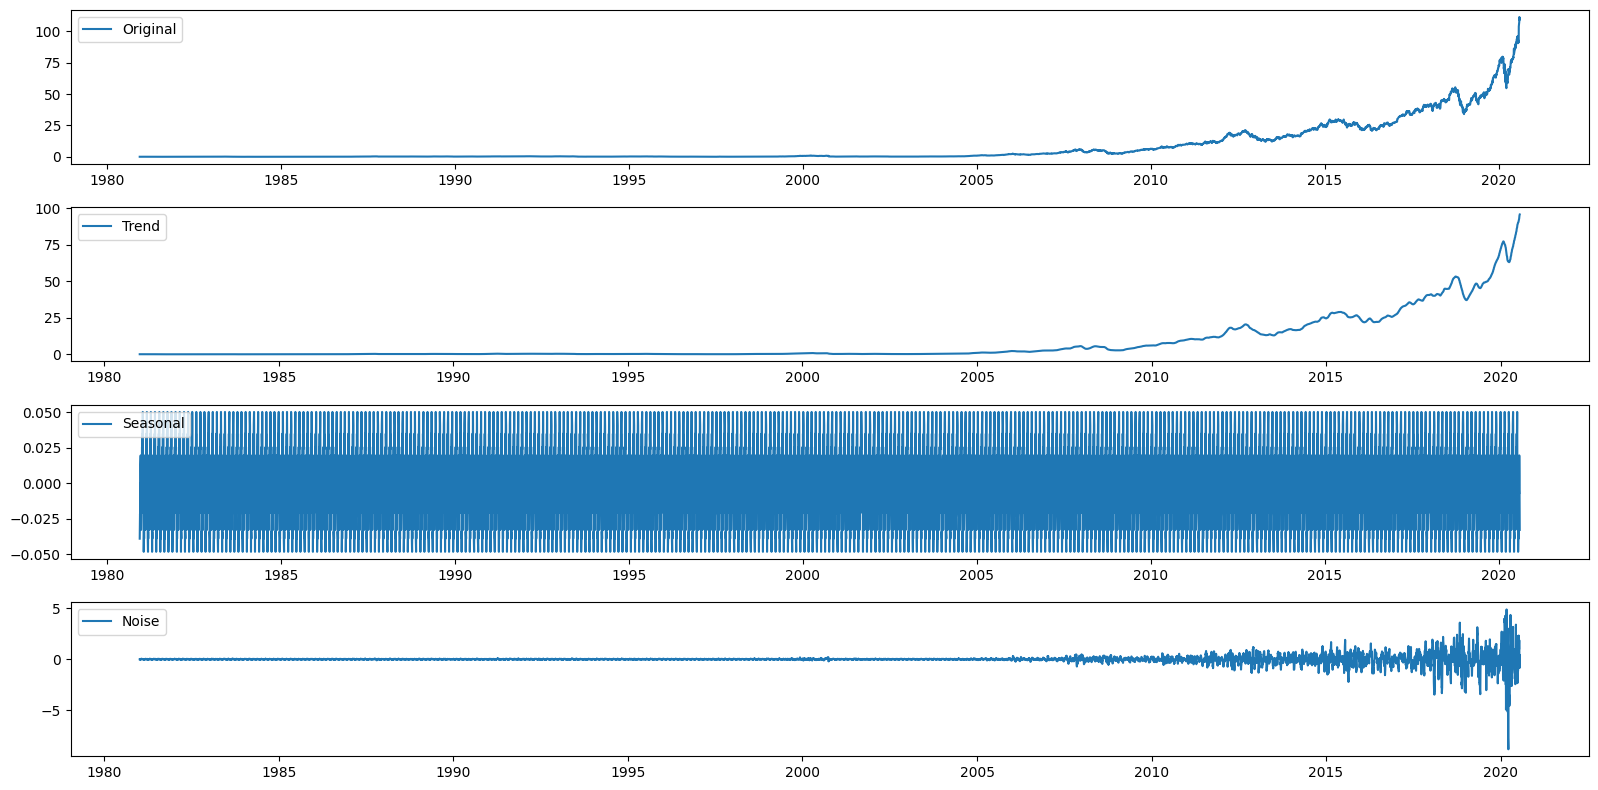

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend_additive, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(resid_additive, label='Noise')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Stationary Test

In [17]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Test Result:')
    print(f'ADF Statistics: {round(result[0],3)}')
    print(f'p-value: {round(result[1],3)}')
    print('Critical Values: ')
    for key, value in result[4].items():
        print(f' {key}: {round(value,3)}')

def kpss_test(series):
    result=kpss(series)
    print('KPSS Test Resul:')
    print(f'KPSS Statistics: {round(result[0],3)}')
    print(f'p-value: {round(result[1],3)}')
    print('Critical Values: ')
    for key, value in result[3].items():
        print(f' {key}: {round(value,3)}')

In [18]:
adf_test(ts)

ADF Test Result:
ADF Statistics: 6.904
p-value: 1.0
Critical Values: 
 1%: -3.431
 5%: -2.862
 10%: -2.567


In ADF Test, If p-value > 0.05 Data is Not Stationary

In [19]:
kpss_test(ts)

KPSS Test Resul:
KPSS Statistics: 9.17
p-value: 0.01
Critical Values: 
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739


In KPSS Test, If p-value < 0.05 Data is Not Stationary

# Making Data Stationary Using Differencing Method

In [20]:
# Applying First Order Differencing
ts_diff = ts.diff().dropna()

In [21]:
adf_test(ts_diff)

ADF Test Result:
ADF Statistics: -11.856
p-value: 0.0
Critical Values: 
 1%: -3.431
 5%: -2.862
 10%: -2.567


In [22]:
kpss_test(ts_diff)

KPSS Test Resul:
KPSS Statistics: 1.577
p-value: 0.01
Critical Values: 
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739


# ARIMA Model

In [23]:
# Model Training and forecasting
train_size = int(len(ts_diff)*0.8)
train_data, test_data = ts_diff[0:train_size], ts_diff[train_size:]

In [24]:
model = ARIMA(train_data, order=(5, 1, 0))
model_fit = model.fit()
prediction = model_fit.predict(start=len(train_data), end=len(ts_diff)-1)

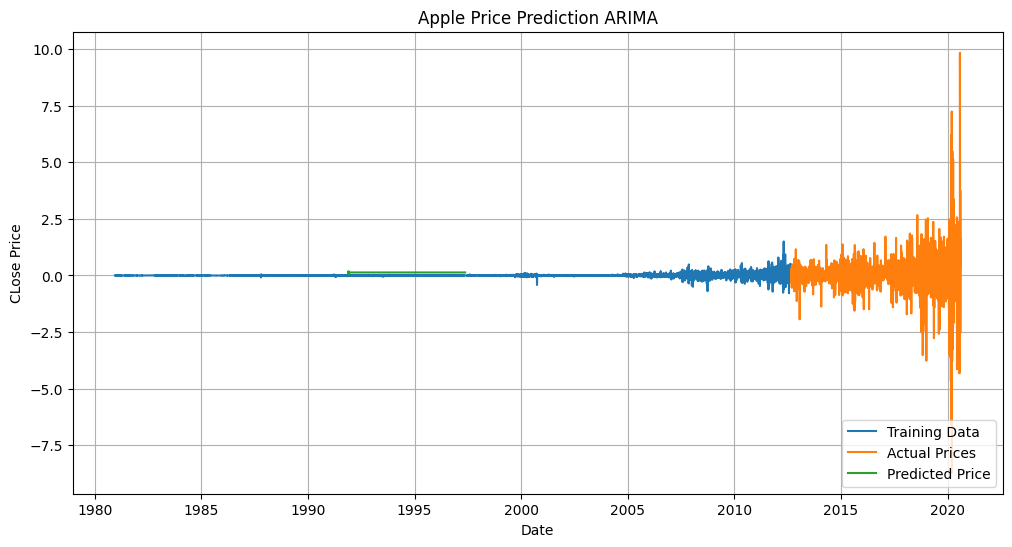

In [25]:
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(prediction.index, prediction)
plt.title('Apple Price Prediction ARIMA')
plt.xlabel('Date')
plt.ylabel('CLose Price')
plt.legend(['Training Data', 'Actual Prices', 'Predicted Price'], loc='lower right')
plt.grid(True)
plt.show()

# SARIMA Model

In [26]:
ts = ts['1985':]

In [27]:
ts_monthly = ts.resample('M').mean().dropna()

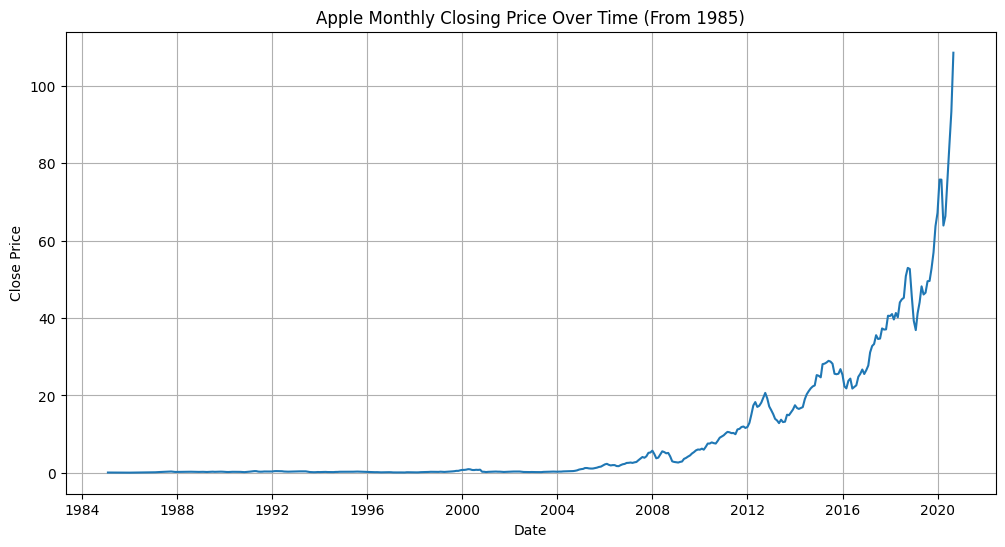

In [28]:
plt.figure(figsize=(12,6))
plt.plot(ts_monthly)
plt.title('Apple Monthly Closing Price Over Time (From 1985)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [29]:
# adf_test
adf_test(ts_monthly) # Data is not Stationary

ADF Test Result:
ADF Statistics: 3.676
p-value: 1.0
Critical Values: 
 1%: -3.446
 5%: -2.869
 10%: -2.571


In [30]:
# using first order differencing for data stationary
ts_monthly = ts_monthly.diff().dropna()
adf_test(ts_monthly)

ADF Test Result:
ADF Statistics: 0.053
p-value: 0.963
Critical Values: 
 1%: -3.446
 5%: -2.869
 10%: -2.571


In [31]:
train_size = int(len(ts_monthly)*0.8)
train_data, test_data = ts_monthly[0:train_size], ts_monthly[train_size:]

In [32]:
sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order = (1,1,1,12))
sarima_model_fit = sarima_model.fit(disp = False)

In [33]:
prediction = sarima_model_fit.predict(start = len(train_data), end = len(ts_monthly-1), dynamic = False)
prediction_index = test_data.index

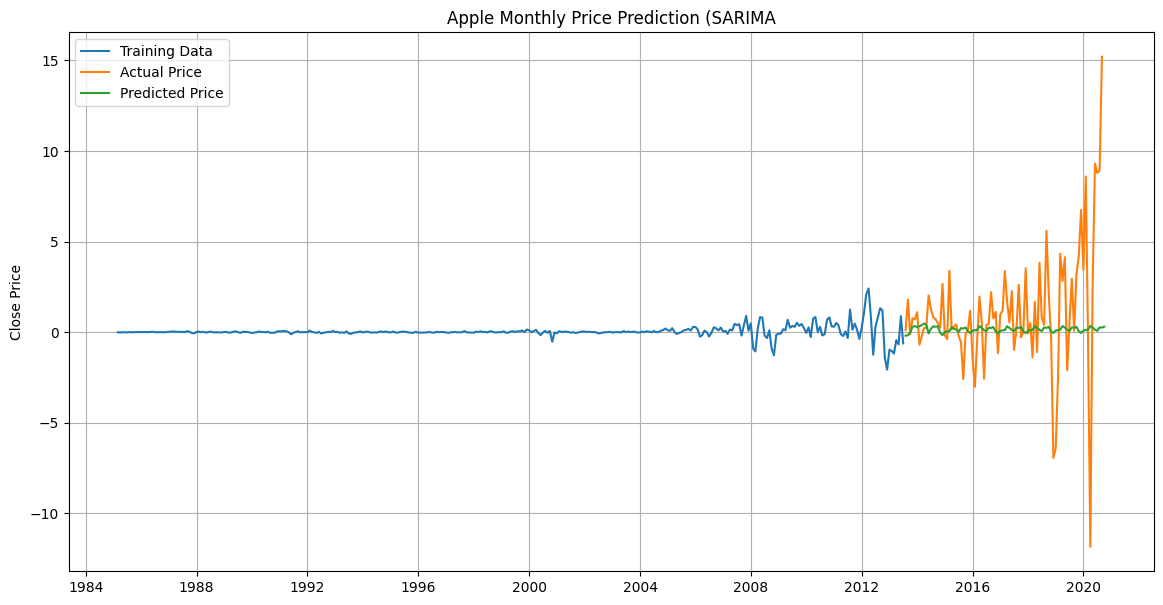

In [34]:
plt.figure(figsize=(14,7))
plt.plot(train_data.index, train_data, label = 'Training Data')
plt.plot(test_data.index, test_data, label = 'Actual Price')
plt.plot(prediction.index, prediction, label = 'Predicted Price')
plt.title('Apple Monthly Price Prediction (SARIMA')
plt.xlabel=('Date')
plt.ylabel('Close Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Prophet Model

In [35]:
prophet_data = df.reset_index().rename(columns = {'Date': 'ds', 'Close':'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

17:56:06 - cmdstanpy - INFO - Chain [1] start processing
17:56:13 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
prediction = prophet_model.make_future_dataframe(periods = 12, freq = 'M')
forecast = prophet_model.predict(prediction)

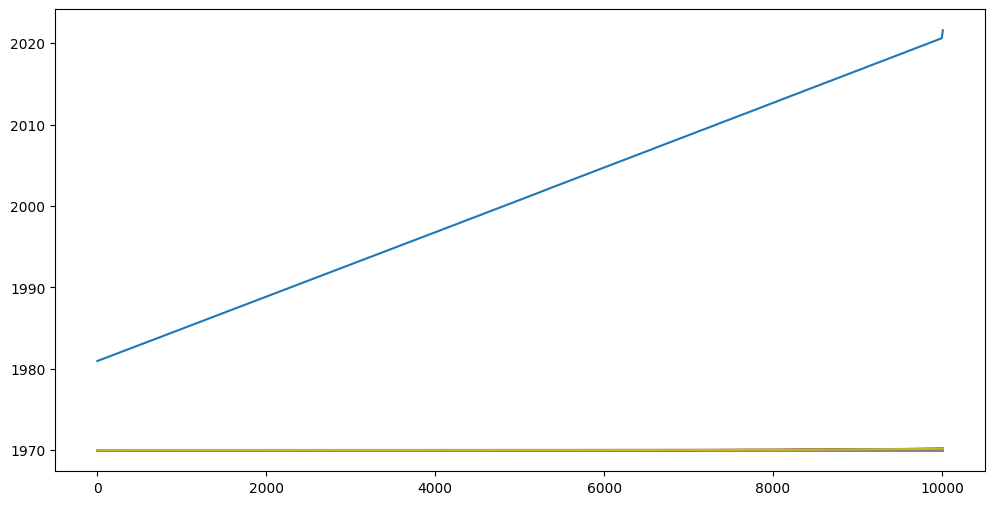

In [37]:
plt.figure(figsize = (12,6))
plt.plot(forecast)
plt.show()

# LSTM

In [38]:
data = df.filter(['Close']) #will use only close prices for now
dataset = data.values 
training_data_len = int(np.ceil(len(dataset) * .80)) 

In [39]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [40]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []
time_step = 60

for i in range(time_step, len(train_data)):
    x_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

#reshaping the data to be 3D (samples, time steps, features) for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [41]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) 

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

In [43]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=32, 
    epochs=100,
    validation_split=0.1, 
    callbacks=[early_stopping] 
)

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - loss: 3.2039e-05 - val_loss: 1.6179e-05
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 2.6712e-06 - val_loss: 1.2643e-05
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 2.4854e-06 - val_loss: 2.2747e-05
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 2.1622e-06 - val_loss: 1.3329e-05
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 1.8399e-06 - val_loss: 1.1272e-05
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 1.9279e-06 - val_loss: 1.8433e-05
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 1.9718e-06 - val_loss: 4.2471e-05
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 1.9397e-06 - val_loss: 3.5282e-05
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - loss: 1.8617e-06 - val_loss: 2.5849e-05
Epoch 10/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 1.7878e-06 - val_loss: 8.4083e-06
Epoch 11/100
224/224 ━━━━━━━━

In [44]:
test_data = scaled_data[training_data_len - time_step:, :]

x_test = []
y_test = dataset[training_data_len:, :] 
for i in range(time_step, len(test_data)):
    x_test.append(test_data[i-time_step:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #unscalign

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
#using rmse

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
Root Mean Squared Error (RMSE): 1.35


TypeError: 'str' object is not callable

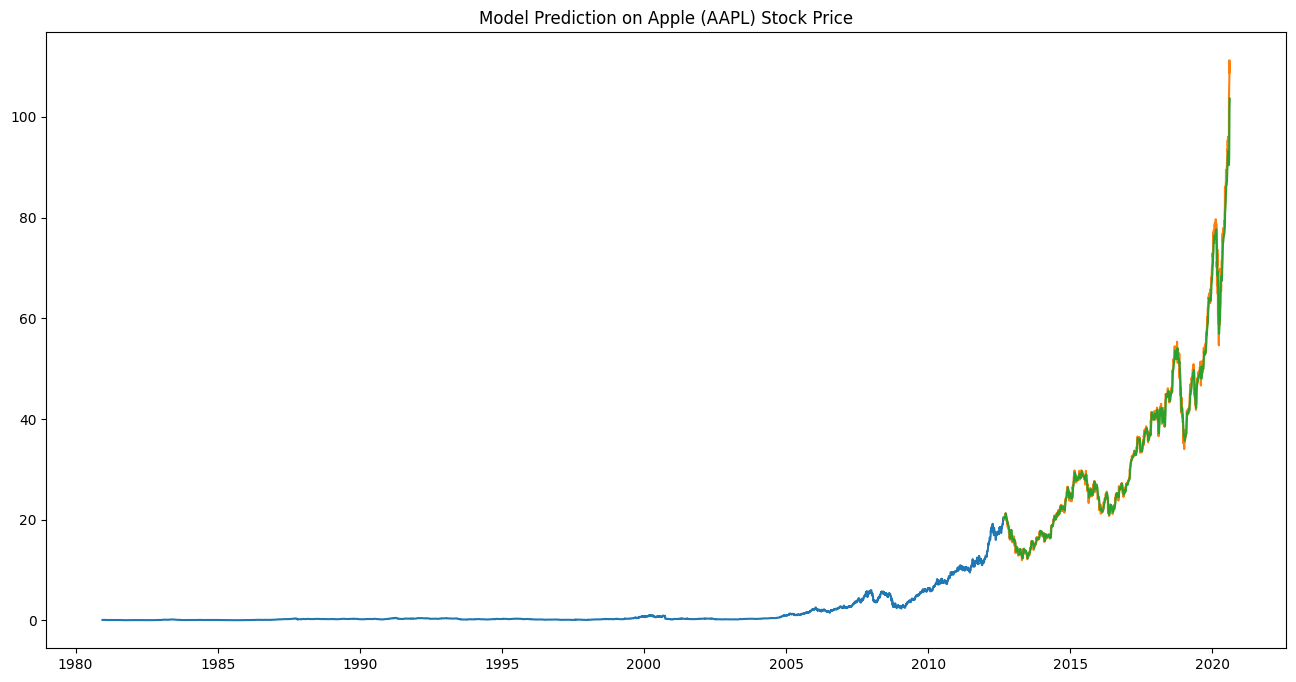

In [47]:

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model Prediction on Apple (AAPL) Stock Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(['Training Data', 'Actual Price', 'Predicted Price'], loc='lower right')
plt.grid(True)
plt.show()